# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
import zarr
#import FWI_Wang2015 as fwi  # Jackie's python script

%matplotlib inline

### run this cell to check if you have LENS2 read access:

In [2]:
samplefile = (
    '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'
    + 'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc'
)
cmd = 'stat ' + samplefile
if os.system(cmd) != 0:
    print('you may not have access')
else:
    print('looks good')

looks good


In [3]:
from dask.distributed import Client
dask.config.set({'distributed.dashboard.link' : 'https://jupyterhub.ucar.edu/dav/user/{USER}/proxy/{port}'})

In [4]:
client = Client()

tornado.application - ERROR - Uncaught exception GET /individual-workers/ws (::1)
HTTPServerRequest(protocol='http', host='jupyterhub.ucar.edu', method='GET', uri='/individual-workers/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/bokeh/server/views/ws.py", line 128, in open
    raise ProtocolError("Subprotocol header is not 'bokeh'")
bokeh.protocol.exceptions.ProtocolError: Subprotocol header is not 'bokeh'
tornado.application - ERROR - Uncaught exception GET /individual-nprocessing/ws (::1)
HTTPServerRequest

In [5]:
client

Client Scheduler: tcp://127.0.0.1:44872 Dashboard: https://jupyterhub.ucar.edu/dav/user/wwieder/proxy/8787,Cluster Workers: 2 Cores: 2 Memory: 322.12 GB


### Fetch cluster

In [6]:
# For use on Casper: ONLY RUN THIS CELL ONCE
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18)
#    to allow dask to allocate more memory to each worker"
'''ncores = 10
nmem = str(int(400 * ncores / ncores)) + 'GB'
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(
    cores=ncores,
    processes=ncores,
    memory=nmem,
    #project='P93300641',
    walltime='1:00:00',
    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
)
# cluster.scale(ncores)
cluster.adapt(minimum_jobs=7, maximum_jobs=7)  # change to 9 w/ 50 ens members
client = Client(cluster)'''

'ncores = 10\nnmem = str(int(400 * ncores / ncores)) + \'GB\'\nfrom dask.distributed import Client\nfrom ncar_jobqueue import NCARCluster\n\ncluster = NCARCluster(\n    cores=ncores,\n    processes=ncores,\n    memory=nmem,\n    #project=\'P93300641\',\n    walltime=\'1:00:00\',\n    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],\n)\n# cluster.scale(ncores)\ncluster.adapt(minimum_jobs=7, maximum_jobs=7)  # change to 9 w/ 50 ens members\nclient = Client(cluster)'

In [7]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0

#cluster

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

In [8]:
#cluster.close()
#client.restart()
#client

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [9]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [10]:
def file_dict(model,mem,field,component,hist=True,freq='monthly'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]
    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        ATM     = '/atm/proc/tseries/'
        LND     = '/lnd/proc/tseries/'
        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h1.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        if component == 'lnd':
            thisdir = topdir+runtype+mm+LND+freq
        if component == 'atm':
            thisdir = topdir+runtype+mm+ATM+freq

        #find all the relevant files
        files = glob.glob(thisdir+'*'+tape+field+'.*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths

In [11]:
def get_file(model,mem,field,year,component,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,component,freq)

    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [12]:
def all_files(model,ens,field,firstyear,lastyear, component,\
              freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,component,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [13]:
def preprocess(ds):
    variables = {"RAIN", "SNOW", "TREFHT", "RHREFHT", "WSPDSRFAV", "TREFHTMX", "PPT"}
    x = list(set(ds.data_vars).difference(variables))
    for v in x:
        ds = ds.set_coords(v)
        ds[v].load()
    return ds

In [14]:
def get_data(model,ens,fields,firstyear,lastyear,component,freq, \
             chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,component,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',
                                    parallel=True,
                                    concat_dim=dims,
                                    chunks=chunks,
                                    preprocess=preprocess)
            tmp = preprocess(tmp)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',
                                       parallel=True,
                                       concat_dim=['time'],
                                       chunks=chunks,
                                       preprocess=preprocess)
                d0 = preprocess(d0)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    tmp = preprocess(tmp)
    
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [15]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [16]:
def month_wts(nyears):
    days_pm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    return xr.DataArray(np.tile(days_pm, nyears), dims='time')

------------
# Start editing here:

### Actually read the data

In [17]:
%%time

lnd_vars = ['RAIN', 'SNOW']
model = 'CESM2'
firstyear = 1850
lastyear  = 2100
chunks    = 1000
freq      = 'daily'

component = 'lnd'
ens = 12+np.arange(1)
nens = len(ens)
ds = get_data(model,ens,lnd_vars,firstyear,lastyear,
              component,freq,chunks=chunks)#.persist()
#_ = wait(ds)
print('lnd read in')

atm_vars = ['RHREFHT', 'WSPDSRFAV', 'TREFHTMX'] 
component = 'atm'
ds_atm = get_data(model,ens,atm_vars,firstyear,lastyear,
                  component,freq,chunks=chunks)#.persist()
#_ = wait(ds_atm)
print('atm read in')

lnd read in
atm read in
CPU times: user 17.6 s, sys: 1.62 s, total: 19.2 s
Wall time: 1min 46s


- 3 ensembles = 500 GB data!
- 10 ens = 1.2 TB, too large for 70 workers

101.336398256

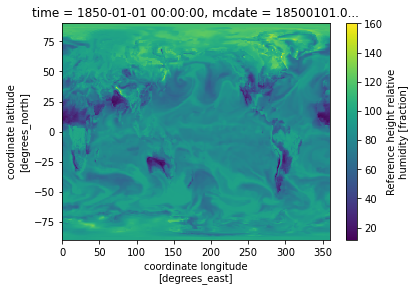

In [18]:
# force coordinate variables to match
ds_atm["lat"] = ds["lat"]
ds_atm["lon"] = ds["lon"]

ds.update(ds_atm[atm_vars])  # <---- CHANGED
del ds_atm

ds[atm_vars[0]].isel(ens=0, time=0).plot();
ds.nbytes/1e9 #GB

In [19]:
# sum rain + snow for precip.
s2d = 3600 * 24  # convert from sec to day
ds['PPT'] = (ds['RAIN'] + ds['SNOW']) * s2d
ds.PPT.attrs['units'] = 'mm/d'
ds.PPT.attrs['long_name'] = 'Total Precip.'

In [20]:
# convert units as needed
# set max RH, used fire weather calculation...
ds["RHREFHT"] = ds.RHREFHT.clip(max=100) 
ds['RHREFHT'].attrs['units'] = 'percent'

ds['TREFHTMX'] = ds['TREFHTMX'] - 273.15  # convert to degC
ds['TREFHTMX'].attrs['units'] = 'degC'

ds['WSPDSRFAV'] = ds['WSPDSRFAV'] * 3600 * 1e-3  #  m/s to km/h
ds['WSPDSRFAV'].attrs['units'] = 'km/h'

ds = ds.rename({'TREFHTMX':'tmax','WSPDSRFAV':'ws','RHREFHT':'rh'})

# mask out missing values
ds = ds.where(ds.landmask.notnull())

In [21]:
del ds['RAIN']
del ds['SNOW']
ds

,Array,Chunk
Bytes,20.26 GB,221.18 MB
Shape,"(1, 91616, 192, 288)","(1, 1000, 192, 288)"
Count,633 Tasks,101 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.26 GB,221.18 MB
Shape,"(1, 91616, 192, 288)","(1, 1000, 192, 288)"
Count,734 Tasks,101 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


-----------------------
# Canadian fire weather model
### based on temp, wind, RH, precip & adjusted for monthly day length by latitude
- **fine fuel mositure code (ffmc)**: calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
- **duff moisture code (dmc)**: calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
- **drought code (dc)**: calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
- **initial spread index (isi)**: calc_isi(wind_kmhr,ffmc):
- **build up index (bui)**: calc_bui(dmc,dc):
- **fire weather index (fwi)**: calc_fwi(isi,bui) 

### Here use implimentation from xclim
https://xclim.readthedocs.io/en/stable/indices.html?highlight=fire#xclim.indices.fire_weather_indexes

In [22]:
import xclim

In [23]:
%%time 
# load data into memory & run
#ds2 = ds.isel(time=slice(0,365)).load()
ds = ds.load()

CPU times: user 1min 9s, sys: 2min 46s, total: 3min 56s
Wall time: 10min 28s


In [24]:
%%time
ds_short = ds.isel(time=0)
DC,DMC,FFMC,ISI,BUI,FWI =  xclim.indices.fire_weather_indexes(tas=ds.tmax, 
                                       pr=ds.PPT, ws=ds.ws,
                                       rh=ds.rh,lat=ds.lat,
                                       ffmc0=xr.full_like(ds_short['PPT'], fill_value=80),
                                       dmc0 =xr.full_like(ds_short['PPT'], fill_value= 6),
                                       dc0  =xr.full_like(ds_short['PPT'], fill_value=16),
                                      )

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xclim/indices/fwi.py:570: RuntimeWarning: invalid value encountered in drought_code
  tas[..., it], pr[..., it], mth[..., it], lat, ind_prevs["DC"]
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xclim/indices/fwi.py:579: RuntimeWarning: invalid value encountered in duff_moisture_code
  ind_prevs["DMC"],
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xclim/indices/fwi.py:413: RuntimeWarning: invalid value encountered in power
  bb <= 1.0, bb, np.exp(2.72 * (0.434 * np.log(bb)) ** 0.647)  # *Eq.30b*#
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xclim/indices/fwi.py:570: RuntimeWarning: invalid value encountered in drought_code
  tas[..., it], pr[..., it], mth[..., it], lat, ind_prevs["DC"]
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xclim/indices/fwi.py:579: RuntimeWarning: invalid value encountered in d

CPU times: user 23min 21s, sys: 31.9 s, total: 23min 52s
Wall time: 23min 16s


In [27]:
FWI = FWI.to_dataset(name='FWI')
FWI['FWI'].attrs['long_name'] = 'fire weather index'

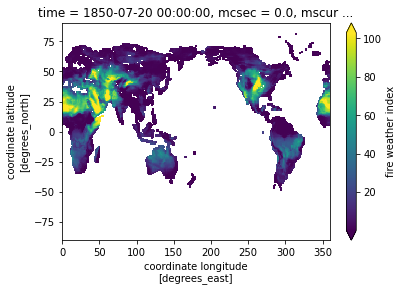

In [39]:
FWI.FWI.isel(time=200).squeeze().plot(robust=True) ;

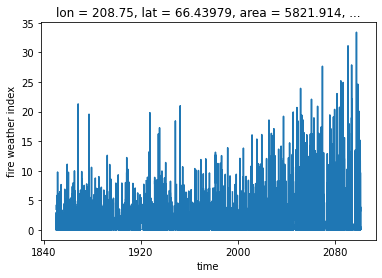

In [38]:
plat, plon, site = 66.4, 209 , 'Alaska'
#plat, plon, site = 39  , 253 , 'Crested Butte'
#plat, plon, site =-13  ,307.5, 'Amazon'

FWI.FWI.sel(lon=plon, lat=plat, method='nearest').squeeze().plot();

### Write out .zarr files to scratch

In [28]:
%%time 
#DC,DMC,FFMC,ISI,BUI,FWI =
## Test for single variable
fout = '/glade/scratch/wwieder/FWI/'
FWI.to_zarr(fout+'FWI_'+str(ens[0])+'.zarr')
print('wrote '+fout+'FWI_'+str(ens[0])+'.zarr')

wrote /glade/scratch/wwieder/FWI/FWI_12.zarr
CPU times: user 1min 6s, sys: 2.73 s, total: 1min 9s
Wall time: 1min 5s


In [36]:
%%time 
BUI = BUI.to_dataset(name='BUI')
BUI['BUI'].attrs['long_name'] = 'build up index'
BUI.to_zarr(fout+'BUI_'+str(ens[0])+'.zarr')
print('wrote '+fout+'BUI_'+str(ens[0])+'.zarr')

ISI = ISI.to_dataset(name='ISI')
ISI['ISI'].attrs['long_name'] = 'initial spread index'
ISI.to_zarr(fout+'ISI_'+str(ens[0])+'.zarr')
print('wrote '+fout+'ISI_'+str(ens[0])+'.zarr')

FFMC = FFMC.to_dataset(name='FFMC')
FFMC['FFMC'].attrs['long_name'] = 'fine fuel mositure code'
FFMC.to_zarr(fout+'FFMC_'+str(ens[0])+'.zarr')
print('wrote '+fout+'FFMC_'+str(ens[0])+'.zarr')

DMC = DMC.to_dataset(name='DMC')
DMC['DMC'].attrs['long_name'] = 'duff mositure code'
DMC.to_zarr(fout+'DMC_'+str(ens[0])+'.zarr')
print('wrote '+fout+'DMC_'+str(ens[0])+'.zarr')
DMC.to_zarr(fout+'DMC_'+str(ens[0])+'.zarr')

DC = DC.to_dataset(name='DC')
DC['DC'].attrs['long_name'] = 'drought code'
DC.to_zarr(fout+'DC_'+str(ens[0])+'.zarr')
print('wrote '+fout+'DC_'+str(ens[0])+'.zarr')

wrote /glade/scratch/wwieder/FWI/DC_12.zarr


In [35]:
DMC

<xarray.Dataset>
Dimensions:   (ens: 1, lat: 192, lon: 288, time: 91616)
Coordinates: (12/20)
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area      (lat, lon) float32 29.95 29.95 29.95 29.95 ... nan nan nan nan
    landfrac  (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    landmask  (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    pftmask   (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    ...        ...
    nsbase    float64 0.0
    nbsec     float64 0.0
    mdt       float64 1.8e+03
    datesec   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    nscur     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    sol_tsi   (time) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Data variables:
    DMC       (ens, lat, lon, time) float32 nan nan nan nan ... nan nan nan nan

--------------
#### End of the useful code...
--------------

### I'm totally confused about how to feed the sample calculation into a function for global calculations


In [64]:
ds = ds.persist()  #go ahead and persist ds for calculations
_ = wait(ds)

<xarray.DataArray 'month' (ens: 2, lat: 192, lon: 288)>
dask.array<where, shape=(2, 192, 288), dtype=float64, chunksize=(2, 192, 288), chunktype=numpy.ndarray>
Coordinates: (12/32)
  * ens       (ens) int64 10 11
  * lat       (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time      object 1850-01-02 00:00:00
    mcdate    float64 1.85e+07
    mcsec     float64 0.0
    ...        ...
    area      (lat, lon) float32 29.95 29.95 29.95 29.95 ... nan nan nan nan
    landfrac  (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    landmask  (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    pftmask   (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    nbedrock  (lat, lon) float64 20.0 20.0 20.0 20.0 20.0 ... nan nan nan nan
    gw        (lat) float64 3.382e-05 0.0002705 0.000541 ... 0.0002705 3.382e-05

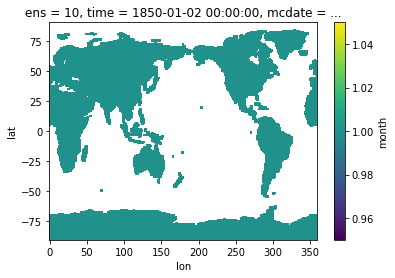

In [132]:
i = 1

exMonth = ds['time.month'].isel(time=i).expand_dims({'ens':ds.ens,'lat':ds.lat,'lon':ds.lon}) \
    .astype('int') \
    .where(ds.landmask.notnull())
exLat = ds['lat'].expand_dims({'ens':ds.ens,'lon':ds.lon}) \
    .where(ds.landmask.notnull())
#exLat.isel(ens=0).plot(x='lon') ;
exMonth.isel(ens=0).plot(x='lon') ;
#ds['time.month'].expand_dims(ds.tmax.isel(time=i).dims)
#ds.dmc.isel(time=(i-1)).isel(ens=1).plot()
exMonth

In [133]:
ds['ffmc'].data[:,1,:,:]

dask.array<getitem, shape=(2, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>

In [141]:
# for i in tqdm(range(1,len(ds.time))):
i = 1
# calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
exMonth = ds['time.month'].isel(time=i).expand_dims({'ens':ds.ens,'lat':ds.lat,'lon':ds.lon}) \
    .astype('int') \
    .where(ds.landmask.notnull())
temp_ffmc = xr.apply_ufunc(
    fwi.calc_ffmc,
    ds.tmax.isel(time=i),
    ds.wind.isel(time=i),
    ds.RHREFHT.isel(time=i),
    ds.PPT.isel(time=i),
    ds.ffmc.isel(time=(i-1)),
    #input_core_dims=[['ens']],
    #output_core_dims=[["ens"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
).rename(FWIlong[0])

# calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
temp_dmc = xr.apply_ufunc( 
    fwi.calc_dmc,
    ds.tmax.isel(time=i),
    ds.RHREFHT.isel(time=i),
    ds.PPT.isel(time=i),
    ds.dmc.isel(time=(i-1)),
    exMonth,    
    exLat,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
).rename(FWIlong[1])

# calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
temp_dc = xr.apply_ufunc( 
    fwi.calc_dc,
    ds.tmax.isel(time=i), 
    ds.PPT.isel(time=i),
    ds.dc.isel(time=(i-1)),
    exMonth,    
    exLat,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
).rename(FWIlong[2])


## Why doesn't it work to write over the values here?
ds['ffmc'].isel(time=i).data = temp_ffmc.values
#ds['dmc'].isel(time=i).values = temp_dmc
ds['dc'].isel(time=i).data = temp_dc.values


# do these need to be applied in the same time loop?
'''
# calc_isi(wind_kmhr,ffmc):
temp_isi = xr.apply_ufunc( 
    fwi.calc_isi,
    ds.wind.isel(time=i), 
    ds.ffmc,isel(time=i),
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
)
    
# calc_bui(dmc,dc):
temp_bui = xr.apply_ufunc( 
    fwi.calc_bui,
    ds.dmc, 
    ds.dc,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
)

# calc_fwi(isi,bui):
temp_fwi = xr.apply_ufunc( 
    fwi.calc_fwi,
    ds.isi, 
    ds.bui,
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=['float32'],
)

'''
print('done!')

done!


Why doesn't it work to write over output correctly? 

Why won't dmc calculate correctly? Doesn't use month correctly?

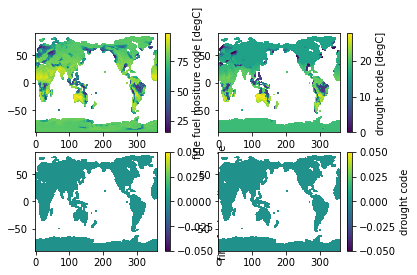

In [144]:
plt.subplot(2,2,1)
temp_ffmc.isel(ens=0).plot() ;
plt.title('')
plt.ylabel('')
plt.xlabel('')

plt.subplot(2,2,2)
temp_dc.isel(ens=0).plot() 
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.subplot(2,2,3)
ds['ffmc'].isel(time=i, ens=0).plot() 
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.subplot(2,2,4)
ds['dc'].isel(time=i, ens=0).plot() 
plt.xlabel('')
plt.ylabel('')
plt.title('') ;

In [114]:
# create arrays to store output
FWIvars = ['ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi']
for v in range(len(FWIvars)):
    tempDS[FWIvars[v]] = xr.DataArray(np.nan, coords=tempDS.tmax.coords)

# loop over days to calculte FWI
for i in tqdm(range(len(tempDS.tmax))):
    # set initial values for
    if i == 0:
        ffmc_prev, dmc_prev,dc_prev = 80, 6,16
    else:
        ffmc_prev = tempDS['ffmc'].data[i - 1]
        dmc_prev  = tempDS['dmc'].data[i - 1]
        dc_prev   = tempDS['dc'].data[i - 1]

    # calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
    tempDS.ffmc[i] = fwi.calc_ffmc(
        tempDS.tmax.data[i],
        tempDS.wind.data[i],
        tempDS.RHREFHT.data[i],
        tempDS.PPT.data[i],
        ffmc_prev,
    )
    # calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
    tempDS.dmc[i] = fwi.calc_dmc(
        tempDS.tmax.data[i],
        tempDS.RHREFHT.data[i],
        tempDS.PPT.data[i],
        dmc_prev,
        tempDS['time.month'][i],
        tempDS['lat'],
    )
    # calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
    tempDS.dc[i] = fwi.calc_dc(
        tempDS.tmax.data[i], tempDS.PPT.data[i], dc_prev, tempDS['time.month'][i], tempDS['lat']
    )

# calc_isi(wind_kmhr,ffmc):
tempDS.isi.data = fwi.calc_isi(tempDS.wind, tempDS.ffmc)
# calc_bui(dmc,dc):
tempDS['bui'].data = fwi.calc_bui(tempDS.dmc, tempDS.dc)
# calc_fwi(isi,bui):
tempDS['fwi'].data = fwi.calc_fwi(tempDS.isi, tempDS.bui)


  0%|          | 0/3650 [00:00<?, ?it/s]

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in calc_bui
  result_data = func(*input_data)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in calc_fwi
  result_data = func(*input_data)


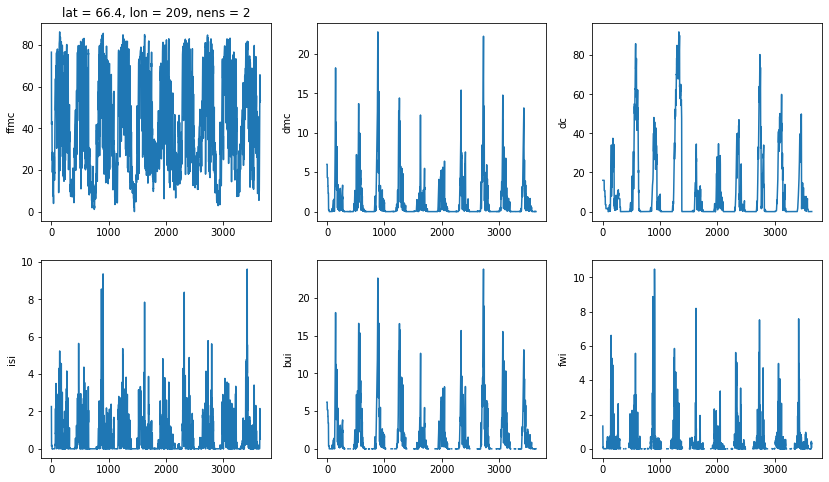

In [49]:
plt.figure(figsize=[14, 8])
for i in range(len(FWIvars)):
    plt.subplot(2, 3, (i + 1))
    if i == 0:
        plt.title('lat = ' + str(plat) + ', lon = ' + str(plon) + ', nens = ' + str(nens))
    plt.plot(tempDS[FWIvars[i]])
    #plt.plot(tempSSP[FWIvars[i]], alpha=0.7)
    plt.ylabel(FWIvars[i]);

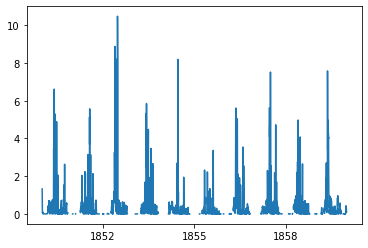

In [50]:
plt.plot(tempDS.time, tempDS['fwi'])
# plt.plot(tempSSP['fwi'])

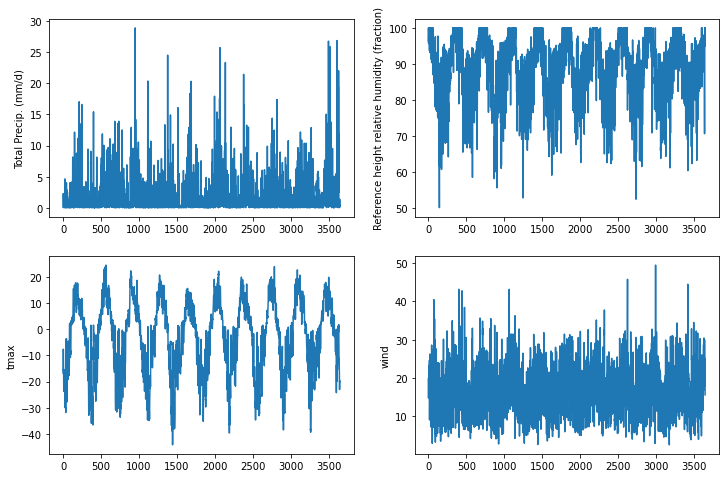

In [52]:
atmVARS = ['PPT', 'RHREFHT', 'tmax', 'wind']
plt.figure(figsize=[12, 8])

for i in range(len(atmVARS)):
    plt.subplot(2, 2, (i + 1))
    plt.plot(tempDS[atmVARS[i]])
    if i < 2:
        plt.ylabel(
            tempDS[atmVARS[i]].attrs['long_name'] + ' (' + tempDS[atmVARS[i]].attrs['units'] + ')'
        )
    else:
        plt.ylabel(atmVARS[i]);

In [2]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-02-24

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

Git hash: f2c26d9d6bf7afdb0315409c0a55dc546a7dc2b7

Git repo: git@github.com:andersy005/cesm-lens.git

Git branch: optimizations

pandas    : 1.2.2
numpy     : 1.20.1
numba     : 0.52.0
matplotlib: 3.3.4
dask      : 2021.2.0
xarray    : 0.16.2
cftime    : 1.4.1
scipy     : 1.6.0

